In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error indice
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [12]:
rand_half_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 9))

In [15]:
rand_half_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287])

In [13]:
bvals_100206_half = bvals_all_100206[rand_half_bval_indice_100206]*1e-3

In [14]:
normalized_scan_100206_half = normalized_scan_100206_full[:, rand_half_bval_indice_100206]

In [16]:
big_b_indice_100206_half = np.where(bvals_100206_half != 0.005)[0]

In [17]:
big_b_indice_100206_half

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141])

In [18]:
bvals_100206_half_no_b5 = bvals_100206_half[big_b_indice_100206_half]

In [19]:
normalized_scan_100206_half_no_b5 = normalized_scan_100206_half[:, big_b_indice_100206_half]

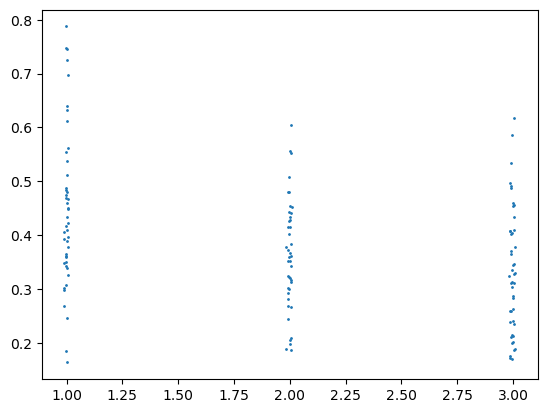

In [20]:
plt.plot(bvals_100206_half_no_b5, normalized_scan_100206_half_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [24]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_half = n_100206_all[:, rand_half_bval_indice_100206]

In [25]:
print(n_100206_half.shape)
print(big_b_indice_100206_half)

(3, 142)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141]


In [26]:
n_100206_half_no_b5 = n_100206_half[:,big_b_indice_100206_half].T
print(n_100206_half_no_b5.shape)

b_values_100206_half_no_b5 = torch.FloatTensor(bvals_100206_half_no_b5)
gradient_directions_100206_half_no_b5 = torch.FloatTensor(n_100206_half_no_b5)

net = BallStickNet(gradient_directions_100206_half_no_b5, b_values_100206_half_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(133, 3)


In [27]:
batch_size = 128
num_batches = len(normalized_scan_100206_half_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_half_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [28]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.25it/s]


Loss: 526.6329887076281
Average Loss: 0.07206253266387905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.07it/s]


Loss: 432.81189025146887
Average Loss: 0.059224396586134216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.10it/s]


Loss: 430.4710751143284
Average Loss: 0.0589040880014133
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.10it/s]


Loss: 429.39581916760653
Average Loss: 0.05875695390908683
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.59it/s]


Loss: 428.9792135870084
Average Loss: 0.05869994712465906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.62it/s]


Loss: 427.3443755256012
Average Loss: 0.058476241861740726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.45it/s]


Loss: 428.07430497696623
Average Loss: 0.05857612273904847
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.57it/s]


Loss: 427.74557579425164
Average Loss: 0.0585311406396075
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.15it/s]


Loss: 427.0153656548355
Average Loss: 0.058431221353973106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.69it/s]


Loss: 426.7345713041723
Average Loss: 0.058392798481687505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▌                                                                                                                                                           | 121/7308 [00:02<00:58, 123.33it/s]

X_batch: 
torch.Size([128, 133])
tensor([[0.4406, 0.2956, 0.1315,  ..., 0.5029, 0.2831, 0.1994],
        [0.5886, 0.3383, 0.2462,  ..., 0.5356, 0.2449, 0.3735],
        [0.0485, 0.0588, 0.0580,  ..., 0.0769, 0.0622, 0.0522],
        ...,
        [0.2694, 0.1290, 0.0778,  ..., 0.2842, 0.1371, 0.0839],
        [0.4704, 0.3960, 0.3046,  ..., 0.4394, 0.2563, 0.2468],
        [0.3899, 0.2535, 0.2289,  ..., 0.2787, 0.1739, 0.1974]])
X_pred: 
torch.Size([128, 133])
tensor([[0.4890, 0.2664, 0.1531,  ..., 0.4803, 0.2705, 0.1612],
        [0.5088, 0.3318, 0.2300,  ..., 0.4900, 0.3417, 0.2485],
        [0.0947, 0.0476, 0.0375,  ..., 0.0904, 0.0495, 0.0403],
        ...,
        [0.2680, 0.1190, 0.0751,  ..., 0.2604, 0.1225, 0.0808],
        [0.4960, 0.3074, 0.2114,  ..., 0.4769, 0.3160, 0.2192],
        [0.3735, 0.2092, 0.1429,  ..., 0.3596, 0.2158, 0.1518]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.30it/s]


Loss: 426.7854713271372
Average Loss: 0.058399763454725945
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.22it/s]


Loss: 426.66674523754045
Average Loss: 0.05838351741071982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.17it/s]


Loss: 426.7363286211621
Average Loss: 0.05839303894651917
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.36it/s]


Loss: 425.66491349367425
Average Loss: 0.05824643041785362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.17it/s]


Loss: 426.4191407500766
Average Loss: 0.05834963611796341
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.58it/s]


Loss: 425.8658444760367
Average Loss: 0.05827392507882276
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.09it/s]


Loss: 425.9235170157626
Average Loss: 0.05828181677829264
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.87it/s]


Loss: 425.58154182345606
Average Loss: 0.05823502214333006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.20it/s]


Loss: 425.1125110727735
Average Loss: 0.05817084169030836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.30it/s]


Loss: 425.5409125967417
Average Loss: 0.05822946258849777
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.93it/s]


Loss: 425.1747583656106
Average Loss: 0.05817935938226746
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.13it/s]


Loss: 425.30491283908486
Average Loss: 0.05819716924453816
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.06it/s]


Loss: 425.2162771015428
Average Loss: 0.05818504065428883
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.50it/s]


Loss: 424.73049948131666
Average Loss: 0.05811856862086982
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.72it/s]


Loss: 424.4694105510134
Average Loss: 0.058082842166257996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.84it/s]


Loss: 424.3713565953076
Average Loss: 0.058069424821470664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.44it/s]


Loss: 424.318208636716
Average Loss: 0.058062152249140124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.18it/s]


Loss: 424.42085005389526
Average Loss: 0.058076197325382495
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.97it/s]


Loss: 423.8243422557134
Average Loss: 0.05799457337927113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.46it/s]


Loss: 423.9557849059347
Average Loss: 0.05801255951093797
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.25it/s]


Loss: 423.4720576053951
Average Loss: 0.05794636803576835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.23it/s]


Loss: 423.8191184825264
Average Loss: 0.057993858577247724
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.26it/s]


Loss: 423.022991156904
Average Loss: 0.057884919424863714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.18it/s]


Loss: 423.3193946406245
Average Loss: 0.05792547819384572
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.71it/s]


Loss: 423.1883113924414
Average Loss: 0.05790754124143971
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.76it/s]


Loss: 423.1136227408424
Average Loss: 0.057897321119436566
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.89it/s]


Loss: 422.41574330069125
Average Loss: 0.05780182584847992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.21it/s]


Loss: 422.45937371160835
Average Loss: 0.05780779607438538
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.66it/s]


Loss: 422.0452887979336
Average Loss: 0.05775113420880318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.67it/s]


Loss: 421.6324506793171
Average Loss: 0.05769464295009813
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.29it/s]


Loss: 421.0197820304893
Average Loss: 0.05761080761227275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.94it/s]


Loss: 420.38392596691847
Average Loss: 0.05752379939339333
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.90it/s]


Loss: 420.58230311400257
Average Loss: 0.05755094459688048
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.56it/s]


Loss: 419.7116541604046
Average Loss: 0.05743180817739526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.58it/s]


Loss: 420.02174438838847
Average Loss: 0.05747423979041988
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.85it/s]


Loss: 419.7497758597601
Average Loss: 0.05743702461135196
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.82it/s]


Loss: 419.2689104247838
Average Loss: 0.057371224743402276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.82it/s]


Loss: 418.7657165529672
Average Loss: 0.05730236953379409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.93it/s]


Loss: 418.7796066014562
Average Loss: 0.057304270197243594
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.33it/s]


Loss: 418.37112195021473
Average Loss: 0.05724837465109671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.06it/s]


Loss: 418.2696754420176
Average Loss: 0.05723449308183055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.88it/s]


Loss: 417.5451776187401
Average Loss: 0.05713535544865081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.19it/s]


Loss: 417.7487453282811
Average Loss: 0.057163210909726474
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.63it/s]


Loss: 417.13527502771467
Average Loss: 0.05707926587680825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.00it/s]


Loss: 416.9730383148417
Average Loss: 0.057057065998199465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.83it/s]


Loss: 416.5696183517575
Average Loss: 0.05700186348546217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.29it/s]


Loss: 416.3641062306706
Average Loss: 0.05697374195821984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.45it/s]


Loss: 415.83673187252134
Average Loss: 0.056901577979272214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.49it/s]


Loss: 415.61151221883483
Average Loss: 0.05687075974532496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.69it/s]


Loss: 415.3920134960208
Average Loss: 0.05684072434264105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.28it/s]


Loss: 415.13317838218063
Average Loss: 0.056805306292033474
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.63it/s]


Loss: 414.9915947972331
Average Loss: 0.056785932511936664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.73it/s]


Loss: 414.6297072339803
Average Loss: 0.05673641314093874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.55it/s]


Loss: 414.75383340311237
Average Loss: 0.05675339811208434
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.27it/s]


Loss: 414.43813437083736
Average Loss: 0.05671019901078782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.14it/s]


Loss: 414.04373816098087
Average Loss: 0.05665623127544894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.56it/s]


Loss: 414.2312308533583
Average Loss: 0.056681887089950506
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.28it/s]


Loss: 414.0163005813956
Average Loss: 0.05665247681737762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.22it/s]


Loss: 414.02962918416597
Average Loss: 0.05665430065464778
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.74it/s]


Loss: 413.7649876496289
Average Loss: 0.056618088074661864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.48it/s]


Loss: 413.7197191871237
Average Loss: 0.05661189370376624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.41it/s]


Loss: 413.55312364711426
Average Loss: 0.05658909737918914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.09it/s]


Loss: 413.25358058023266
Average Loss: 0.05654810900112653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.45it/s]


Loss: 413.5386343272403
Average Loss: 0.05658711471363441
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.36it/s]


Loss: 413.2517222540919
Average Loss: 0.05654785471457196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.13it/s]


Loss: 413.3425436273683
Average Loss: 0.056560282379223906
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.39it/s]


Loss: 413.0402270969935
Average Loss: 0.0565189144905574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.91it/s]


Loss: 412.91494660195895
Average Loss: 0.056501771565675825
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.47it/s]


Loss: 412.85032091778703
Average Loss: 0.056492928423342505
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.07it/s]


Loss: 412.62517343857326
Average Loss: 0.05646212006548621
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.85it/s]


Loss: 412.8647635842208
Average Loss: 0.056494904705011055
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.98it/s]


Loss: 412.4623196525499
Average Loss: 0.056439835748843724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.95it/s]


Loss: 412.52452204795554
Average Loss: 0.05644834729720245
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.89it/s]


Loss: 412.6532158572227
Average Loss: 0.05646595728752363
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.02it/s]


Loss: 412.38871557312086
Average Loss: 0.05642976403573082
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.46it/s]


Loss: 412.28506124182604
Average Loss: 0.05641558035602436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.12it/s]


Loss: 412.2933762355242
Average Loss: 0.05641671814936018
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.32it/s]


Loss: 412.0885778882075
Average Loss: 0.056388694292310824
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.01it/s]


Loss: 412.3760016444139
Average Loss: 0.05642802430821209
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.98it/s]


Loss: 412.0128399473615
Average Loss: 0.0563783305894036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.42it/s]


Loss: 411.9954776521772
Average Loss: 0.05637595479641177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.42it/s]


Loss: 411.9996623804327
Average Loss: 0.056376527419325764
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.50it/s]


Loss: 411.85224795830436
Average Loss: 0.056356355768788224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.31it/s]


Loss: 411.7702075331472
Average Loss: 0.05634512965697143
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.03it/s]


Loss: 411.7950597857125
Average Loss: 0.05634853034834599
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.43it/s]


Loss: 411.8060221117921
Average Loss: 0.05635003039296553
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.11it/s]


Loss: 411.623578469269
Average Loss: 0.056325065471985354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.59it/s]


Loss: 411.7907847641036
Average Loss: 0.05634794537001965
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.82it/s]


Loss: 411.42180560552515
Average Loss: 0.056297455611046134
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.82it/s]


Loss: 411.59820633684285
Average Loss: 0.05632159364215146
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.58it/s]


Loss: 411.2732666102238
Average Loss: 0.05627713007802734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.06it/s]


Loss: 411.393269283697
Average Loss: 0.056293550805103586
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.11it/s]


Loss: 411.6215621745214
Average Loss: 0.056324789569584206
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.27it/s]


Loss: 411.2592596190516
Average Loss: 0.056275213412568637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.38it/s]


Loss: 411.3984633041546
Average Loss: 0.056294261535872275
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.88it/s]


Loss: 411.04973673517816
Average Loss: 0.056246543067211024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.19it/s]


Loss: 411.1634530981537
Average Loss: 0.0562621035985432
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.89it/s]


Loss: 411.2739078330342
Average Loss: 0.05627721782061223
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.93it/s]


Loss: 411.1897415048443
Average Loss: 0.0562657008079973
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.52it/s]


Loss: 411.1017068226356
Average Loss: 0.05625365446396218
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.39it/s]


Loss: 411.10116832726635
Average Loss: 0.05625358077822473
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.03it/s]


Loss: 411.33394451788627
Average Loss: 0.056285433021057235
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.93it/s]


Loss: 410.92868958064355
Average Loss: 0.05622997941716524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.53it/s]


Loss: 410.9806711403653
Average Loss: 0.05623709238373909
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.43it/s]


Loss: 410.9762007119134
Average Loss: 0.05623648066665482
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.43it/s]


Loss: 411.12131048645824
Average Loss: 0.05625633695764344
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.09it/s]


Loss: 410.7274714622181
Average Loss: 0.056202445465547084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.84it/s]


Loss: 410.95773673197255
Average Loss: 0.05623395412314895
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.88it/s]


Loss: 410.88301110453904
Average Loss: 0.0562237289415078
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.63it/s]


Loss: 410.8987622933928
Average Loss: 0.0562258842766
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.98it/s]


Loss: 410.83572462084703
Average Loss: 0.0562172584319714
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.10it/s]


Loss: 410.6699511972256
Average Loss: 0.056194574602794964
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.56it/s]


Loss: 410.72983875661157
Average Loss: 0.05620276939745643
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.63it/s]


Loss: 410.513064984465
Average Loss: 0.0561731068670587
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.02it/s]


Loss: 410.64010662562214
Average Loss: 0.05619049078073647
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.68it/s]


Loss: 410.50569218210876
Average Loss: 0.05617209799974121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.36it/s]


Loss: 410.8970326373819
Average Loss: 0.056225647596795554
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.71it/s]


Loss: 410.5276293035131
Average Loss: 0.056175099795226204
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.98it/s]


Loss: 410.4265087293461
Average Loss: 0.056161262825581024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.26it/s]


Loss: 410.3510698727332
Average Loss: 0.05615094004826672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.27it/s]


Loss: 410.3858363132458
Average Loss: 0.056155697360871074
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.09it/s]


Loss: 410.5121648069471
Average Loss: 0.056172983690058444
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.77it/s]


Loss: 410.26749875047244
Average Loss: 0.056139504481454904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.48it/s]


Loss: 410.34092127066106
Average Loss: 0.05614955135066517
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.41it/s]


Loss: 410.3336845787708
Average Loss: 0.05614856110820618
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.07it/s]


Loss: 410.4672327309381
Average Loss: 0.05616683534906104
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.32it/s]


Loss: 410.41056001605466
Average Loss: 0.05615908046196698
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.40it/s]


Loss: 410.35124324820936
Average Loss: 0.056150963772332974
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.62it/s]


Loss: 410.42358830664307
Average Loss: 0.05616086320561618
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.47it/s]


Loss: 410.35941185825504
Average Loss: 0.056152081535065006
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.46it/s]


Loss: 410.1996573396027
Average Loss: 0.05613022131083781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.51it/s]


Loss: 410.2196889251936
Average Loss: 0.056132962359769244
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.36it/s]


Loss: 410.12241141544655
Average Loss: 0.05611965126100801
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.10it/s]


Loss: 410.34318598359823
Average Loss: 0.0561498612457031
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.21it/s]


Loss: 410.2034410950728
Average Loss: 0.056130739066101915
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.06it/s]


Loss: 410.2303659594618
Average Loss: 0.05613442336610041
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.48it/s]


Loss: 410.0641521429643
Average Loss: 0.056111679275173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.09it/s]


Loss: 410.1679575161543
Average Loss: 0.05612588362290015
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.13it/s]


Loss: 409.99136304459535
Average Loss: 0.05610171908108858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.12it/s]


Loss: 410.1066270733718
Average Loss: 0.05611749138935027
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.51it/s]


Loss: 409.95293649914674
Average Loss: 0.056096460933107106
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.54it/s]


Loss: 409.9754924888257
Average Loss: 0.05609954741226405
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.34it/s]


Loss: 409.9512160564773
Average Loss: 0.056096225514022616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.24it/s]


Loss: 410.02464320138097
Average Loss: 0.05610627301606198
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.75it/s]


Loss: 410.08552452526055
Average Loss: 0.056114603793823284
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.20it/s]


Loss: 410.12123340391554
Average Loss: 0.056119490066217234
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.42it/s]


Loss: 409.9355263391044
Average Loss: 0.05609407859046311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.39it/s]


Loss: 409.924741466064
Average Loss: 0.05609260282786864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.88it/s]


Loss: 409.878798996564
Average Loss: 0.0560863162283202
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.17it/s]


Loss: 409.9275156671647
Average Loss: 0.056092982439404034
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.78it/s]


Loss: 410.03684030356817
Average Loss: 0.056107942022929416
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.23it/s]


Loss: 409.90170227736235
Average Loss: 0.05608945022952413
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.38it/s]


Loss: 409.76415401371196
Average Loss: 0.0560706286280394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.65it/s]


Loss: 409.91110096895136
Average Loss: 0.05609073631211704
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.49it/s]


Loss: 409.778373287525
Average Loss: 0.05607257434147852
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.75it/s]


Loss: 409.8626482244581
Average Loss: 0.056084106215716766
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.24it/s]


Loss: 409.85356030403636
Average Loss: 0.056082862657914116
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.50it/s]


Loss: 409.78479206818156
Average Loss: 0.05607345266395478
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.73it/s]


Loss: 409.7125925659202
Average Loss: 0.056063573148046005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.96it/s]


Loss: 409.74030608753674
Average Loss: 0.05606736536501598
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.29it/s]


Loss: 409.7277651457116
Average Loss: 0.056065649308389656
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.01it/s]


Loss: 409.81871534860693
Average Loss: 0.05607809460161562
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.03it/s]


Loss: 409.66910684714094
Average Loss: 0.05605762272128365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.56it/s]


Loss: 409.679258069722
Average Loss: 0.05605901177746606
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.48it/s]


Loss: 409.67665661801584
Average Loss: 0.056058655804326195
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.66it/s]


Loss: 409.60979185951874
Average Loss: 0.05604950627524887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.74it/s]


Loss: 409.64082052279264
Average Loss: 0.05605375212408219
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.11it/s]


Loss: 409.60384960938245
Average Loss: 0.05604869315946667
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.27it/s]


Loss: 409.62238165480085
Average Loss: 0.05605122901680362
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.08it/s]


Loss: 409.6124450250063
Average Loss: 0.05604986932471351
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.55it/s]


Loss: 409.59039883245714
Average Loss: 0.05604685260433185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.85it/s]


Loss: 409.5309182216879
Average Loss: 0.05603871349503119
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.92it/s]


Loss: 409.5473205188755
Average Loss: 0.056040957925407156
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.43it/s]


Loss: 409.51691843918525
Average Loss: 0.05603679781598046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.55it/s]


Loss: 409.5500254307408
Average Loss: 0.056041328055656925
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.23it/s]


Loss: 409.45499935979024
Average Loss: 0.05602832503554875
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.68it/s]


Loss: 409.5913611156866
Average Loss: 0.0560469842796506
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.76it/s]


Loss: 409.44090126338415
Average Loss: 0.056026395903582944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.80it/s]


Loss: 409.46883193054236
Average Loss: 0.05603021783395489
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.31it/s]


Loss: 409.5484696943313
Average Loss: 0.056041115174374836
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.76it/s]


Loss: 409.4349902544636
Average Loss: 0.056025587062734486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.90it/s]


Loss: 409.6675472143106
Average Loss: 0.056057409306829585
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.65it/s]


Loss: 409.54287665104493
Average Loss: 0.05604034984278119
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.63it/s]


Loss: 409.53900852799416
Average Loss: 0.056039820542965815
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.16it/s]


Loss: 409.3930364358239
Average Loss: 0.05601984625558619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.61it/s]


Loss: 409.59776625572704
Average Loss: 0.05604786073559483
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.62it/s]


Loss: 409.46213319920935
Average Loss: 0.05602930120405163
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.34it/s]


Loss: 409.4937251287047
Average Loss: 0.056033624128175245
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.97it/s]


Loss: 409.2835322660394
Average Loss: 0.056004862105369375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.09it/s]


Loss: 409.49267362756655
Average Loss: 0.05603348024460407
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.87it/s]


Loss: 409.50588146736845
Average Loss: 0.05603528755711117
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.16it/s]


Loss: 409.48050283268094
Average Loss: 0.0560318148375316
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.85it/s]


Loss: 409.43095489335246
Average Loss: 0.05602503487867439
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.04it/s]


Loss: 409.41492192377336
Average Loss: 0.05602284098573801
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.83it/s]


Loss: 409.4185669098515
Average Loss: 0.056023339752305897
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.49it/s]


Loss: 409.387591824634
Average Loss: 0.05601910123489792
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.21it/s]


Loss: 409.32587872166187
Average Loss: 0.0560106566395268
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.70it/s]


Loss: 409.51806450029835
Average Loss: 0.05603695463879288
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.77it/s]

Loss: 409.3379597936291
Average Loss: 0.05601230976924317
Done, best loss: 409.2835322660394
Done


<All keys matched successfully>

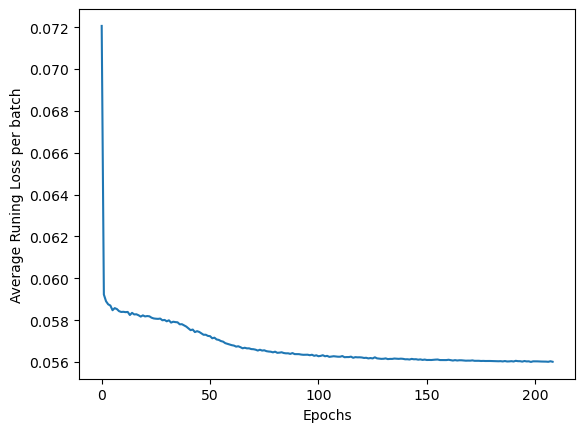

In [29]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [30]:
torch.save(final_model, 'model_100206_half_03.pt')